In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as n
import os.path
import datetime as dt


Populating the interactive namespace from numpy and matplotlib


In [2]:
from geometry import *
from vpython_utils import *

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
n.set_printoptions(suppress=True)

In [9]:
class Satellite():
    def __init__(self, properties):
        self.properties = properties
        self.subsystems = {}
        # 0-3: long edges, 4: top, 5: bottom, 6: spitroast angle
        self.starting_orientation = n.array([[1,0,0],[0,1,0],[-1,0,0],[0,-1,0],[0,0,1],[0,0,-1]]).astype(n.float32)
        self.current_orientation  = n.array([[1,0,0],[0,1,0],[-1,0,0],[0,-1,0],[0,0,1],[0,0,-1]]).astype(n.float32)
        self.normal_angles = n.zeros(6, n.float32)
        self.area_ratio = n.zeros(6,n.float32)
        self.angles = n.zeros(6,n.float32)
        self.gen_powers_per_face = [[] for i in range(6)]
        self.gen_powers_total = []
        self.ts = []
        self.zrot_angle = 0
        
    def a_e(self):
        pass
    
    
    def add_subsystem(self, name, voltage, power_modes = None):
        self.subsystems[name] = Subsystem(name, voltage, power_modes)
        
        
        
        
    def update_face_orientations(theta, phi, psi, sun_vector):
        for i in range(6):
            self.current_orientation[i] = rotate_vector(self.starting_orientation[i],theta, phi, psi )
            self.area_ratio[i], self.normal_angles[i] = dot_and_angle(sun_vector, self.current_orientation[i])
            
    def generate_power(self, t, eclipse_frac):
    
        total_power_gen = 0
        for i in range(self.starting_orientation.shape[0]):
            self.current_orientation[i] = rotate_vector(self.starting_orientation[i],orbit['theta'],orbit['phi'], new_psi )
            self.area_ratio[i], self.normal_angles[i] = dot_and_angle(solar_sys['sun_vector'], self.current_orientation[i])

            power_gen = -1.0 * solar_sys['solar_flux'] * (1/10000.0) * self.cell_areas[i] * 0.3 * self.area_ratio[i]
            if power_gen < 0 or t < eclipse_frac: power_gen = 0
            total_power_gen += power_gen
            self.gen_powers_per_face[i].append(power_gen)
        self.gen_powers_total.append(total_power_gen)    
        self.ts.append(t)

class Subsystem():
    def __init__(self, name, voltage, power_modes = None):
        self.name = name
        self.v = voltage
        self.power_modes = power_modes # can be dict or constant, unit is mW

    def run(self,mode = 'default'):
        if type(self.power_modes) == dict:
            assert (mode in self.power_modes.keys()), "Provide valid operational mode"
            power = self.power_modes[mode]
        else: power = self.power_modes
        
        assert power is not None, "Subsystem incorrectly configured"
        
        return power / self.v # returns the current draw in mA
    


NameError: name 'self' is not defined

In [ ]:
solar_sys ={'sun_dist' : 50e6,
            'sun_radius' : 20e6,
            'earth_radius' :6.371e6,
            'flip_o' : (1,2,0),
            'flip_v' : (0,2,1),
            'sun_vector' : (0,1,0),
            'solar_flux' : 1373.0} # W m^-2, constant 


orbit = {'period' : 90,
         'altitude' : 10e5,
         'phi' : n.pi/2,
         'theta' : 0,
         'zrot_period' : 1,
         'psi_mode' : 'fast-pole-flip'}

satellite_props = {'sizefactor': 5e6}

sim_props = {'n_orbits' : 6,
             'total_time': None, # minutes, overrides n_orbit if set
             'dt' : 0.5, #minutes
             'sim_time' :10, # seconds
             }

In [ ]:
heron = Satellite(satellite_props)
heron.orbit = orbit

heron.add_subsystem('obc', 3.3, 50)
heron.add_subsystem('com', 5, {'default' : 100, 'tx' : 3000})
heron.add_subsystem('pay',3.3, {'default' : 50, 'data_collection' : 400})
heron.add_subsystem('mtr',5, {'default' : 0, 'actuate' : 2000})
heron.add_subsystem('htr_batt', 5)
heron.add_subsystem('htr_pay', 5)
heron.cell_areas = n.array([30.18*6, 30.18*6, 30.18*6, 30.18*6, 0,0])

In [ ]:
from vpython import *

In [ ]:
face_colors = [color.blue, color.green, color.orange, color.purple, color.yellow, color.cyan]

In [ ]:
sc, solar_sys, heron = make_orbit_scene(solar_sys, heron)

sc_v,solar_sys, heron = make_view_scene(solar_sys, heron)

g = graph(title='Power Generation over time', xtitle="time (m)" , ytitle = 'vector', fast=False)
solar_power_curves = [gcurve(graph=g , color = face_colors[i], label = 'Face ' + str(i)) for i in range(6)]
solar_power_curves += [gcurve(graph=g, color=color.red, label='Total Power')]

In [ ]:
g.xmin = 0
g.xmax = 300

In [5]:
for a in solar_power_curves: a.delete()

heron.orbit['phi'] = 0
heron.orbit['theta'] = 0.2
simulate(sim_props, heron, solar_sys, solar_power_curves, g)

NameError: name 'solar_power_curves' is not defined

In [6]:
g

NameError: name 'g' is not defined

In [11]:
(heron.gen_powers.sum(axis=0)).mean()

3.9750328

In [16]:
heron.sat3d.clear_trail()

In [14]:
g.xmin = 100

In [14]:
area_curves[0].plot([1,2])

## Some Geometry
### Orbits off the xz-plane (ltdn != 12) 

From the description [here](https://math.stackexchange.com/questions/1742723/equation-of-a-circle-in-spherical-coordinates) we can paramterize the orbit on the x-z plane, and then apply the rotation matrix to it. So, first, the orbit on the xz plane where $ 0 \leq t < 2 \pi$ : 

$$
\begin{bmatrix}
x \\ y \\ z
\end{bmatrix} 
= 
\begin{bmatrix}
r \sin t \\ 0 \\  r \cos t
\end{bmatrix}
$$

Let's define $\phi$ as the angle that determines the LTDN of the satellite. So, $\phi=0$ indicates an LTDN of 6, and $\phi=\pi/2$ is an LTDN of 12. 

Define $\theta$ as the inclination of the satellite. So, $\theta=0$ is a 90-degree inclination. 

Now, assuming that the sun is located at $x=0,y=d_{sun},z=0$, and that the dawn/dusk orbit with an LTDN of 6pm is on the xz-plane, our angles correspond to the image in the link [here](http://mathworld.wolfram.com/EulerAngles.html) (don't be confused by the circle in the image, that does not correspond to our orbit.

So, that means our angles are Euler angles! We can apply rotation matrices $D$ and $C$ as defined there to get our new orbits!



### The flip

**NOTE: $\theta$ should be replaced with $\psi$ in the following text, and $\alpha$ is actually $\phi - \pi/2$**

For now, we assume that the 'up' axis of the satellite will make an angle $\theta$ with the z-axis of our earth model. At $t = 0$, $\theta = 0$. At $t = 0.25$, we have $\theta = \pi$ since the satellite will be "upside down" when passing the equator. At $t = 0.5$, $\theta = 2\pi$. For the second half of the orbit, it loops around the same way.

Other than these points, the rate of change of $\theta$ is currently unclear. Few possible ways of modelling it:

* Linear : $\theta = 4 \pi t$
* Trigonometric, with fast flipping at the poles: 

$$
\frac{d\theta}{dt} \propto 1 + \cos(4\pi t) \\
\theta(t) = 4 \pi(t + \frac{1}{4\pi} \sin (4\pi t)) \\
\theta(t) = 4 \pi t + \sin (4\pi t))
$$

* Trigonometric, with slow flipping at the poles: 

$$
\frac{d\theta}{dt} \propto 1 - \cos(4\pi t) \\
\theta(t) = 4 \pi(t - \frac{1}{4\pi} \sin (4\pi t)) \\
\theta(t) = 4 \pi t - \sin (4\pi t))
$$


OK, so now we have a way of calculating the angle based on the current time. Now we need to convert this angle to a vector from the origin.

If we have a ltdn of 12 (alpha = 0), we can draw a unit circle on the xy-plane and based on a given $\theta$ we can calculate:

$$
\begin{bmatrix} x \\ y \\ z \end {bmatrix} = \begin{bmatrix} \sin \theta \\ \cos \theta \\ 0 \end {bmatrix}
$$

For cases where we have a non-zero $\alpha$, we can apply the rotation matrix to these coordinates to get basically the same exact formula:

$$
\begin{bmatrix}
x \\ y \\ z
\end{bmatrix} 
= 
\begin{bmatrix}
 \sin \theta \cos \alpha \\  \cos \theta \\ -  \sin \theta \sin \alpha
\end{bmatrix}
$$

Note the difference here - $\theta$ is a time-dependent quantity! So it's probably more correct to replace it with $\theta(t)$.

To calculate the "up" direction for the satellite, we will use the `get_theta` function defined above (with a few different options for the theta approximation). Since the math is essentially identical, to convert this theta into a vector we will use the `orbit_xyz` function. The only difference will be a factor of $2\pi$ in the inputs.

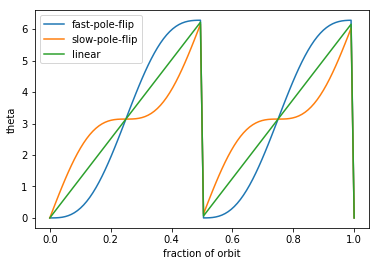

In [18]:
for method in ['fast-pole-flip', 'slow-pole-flip', 'linear']:
    thetas = []
    for i in n.linspace(0, 1, 100):
        thetas.append(get_theta(i, method))
    plot(n.linspace(0,1,100),thetas, label=method)
    xlabel('fraction of orbit')
    ylabel('theta')
    legend()
    

### Viewing direction and projected area

So, to calculate the projected area (as viewed by the sun) of each side of the satellite, we have two pieces of information:
* An 'up' vector
* $\alpha$ degrees of rotation around the up axis corresponding to the spitroasting.

OK, so what we want is the area of the projection of at most 3 faces of the satellite on the xz-plane. Let's number the faces, going clockwise looking down from the top of the satellite, 0-3, top is 4 and bottom is 5.

We want to calculate the angle between the normal of each face and the normal of our projection plane. 

As long as we have the up vector, we don't care about where the satellite is within its orbit. The circular motion does not change the up vector.

First start in the coordinate frame of the satellite. -x face is 0, -y is 1, +x is 2, +y is 3, +z is 4 and -z is 5. At this point, the normal vectors for the faces are `[-1,0,0], [0,-1,0], [1,0,0], [0,1,0], [0,0,1], [0,0,-1]` respectively. Then, multiply this by a rotation around the z-axis by $\alpha$. Can do this with the `rotate_vector`2